# Age Prediction Using XGBoost

## Description
This notebook focuses exclusively on implementing **XGBoost** for predicting **age of death** using a structured dataset. XGBoost is a powerful **gradient boosting algorithm** known for its efficiency and high performance in structured data tasks. It is widely used in machine learning competitions and real-world applications due to its scalability, robustness, and feature importance insights.

### **Why This Notebook?**
I have structured this repository to explore multiple modeling approaches **separately**, ensuring that each model is implemented in a dedicated notebook. This notebook is specifically designed to:
- **Showcase XGBoost’s capabilities** in handling structured tabular data.
- **Compare its performance against other models** (which are implemented in separate notebooks).
- **Understand the strengths and limitations** of XGBoost in a regression setting.

### **What’s Covered in This Notebook?**
✅ **Data Preprocessing**: Handling missing values, categorical encoding, and feature scaling.  
✅ **XGBoost Implementation**: Training an optimized **gradient boosting model** on the dataset.  
✅ **Hyperparameter Tuning**: Using techniques such as grid search or random search to optimize performance.  
✅ **Training & Evaluation**: Assessing model performance using metrics like RMSE, MAE, and feature importance analysis.  

Each model is trained and evaluated separately to highlight its strengths and weaknesses. Stay tuned for additional notebooks showcasing **novel techniques and alternative modeling approaches**.


# Import Libraries, Dependencies and Dataset


In [4]:
!pip install xgboost > /dev/null 2>&1


In [32]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import kagglehub
import os

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error, mean_squared_log_error, explained_variance_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from scipy.stats import norm

In [2]:
# Dataset download
path = kagglehub.dataset_download("imoore/age-dataset")

print("Path to dataset files:", path)
dataset_path = "/home/codespace/.cache/kagglehub/datasets/imoore/age-dataset/versions/1"
print("Files in dataset directory:", os.listdir(dataset_path))

file_path = os.path.join(dataset_path, "AgeDataset-V1.csv")  #
df = pd.read_csv(file_path)

print(df.head())
print(df.info())
print(df.describe())

Path to dataset files: /home/codespace/.cache/kagglehub/datasets/imoore/age-dataset/versions/1
Files in dataset directory: ['AgeDataset-V1.csv']
     Id                     Name  \
0   Q23        George Washington   
1   Q42            Douglas Adams   
2   Q91          Abraham Lincoln   
3  Q254  Wolfgang Amadeus Mozart   
4  Q255     Ludwig van Beethoven   

                                 Short description Gender  \
0   1st president of the United States (1732–1799)   Male   
1                      English writer and humorist   Male   
2  16th president of the United States (1809-1865)   Male   
3        Austrian composer of the Classical period   Male   
4           German classical and romantic composer   Male   

                                             Country  Occupation  Birth year  \
0  United States of America; Kingdom of Great Bri...  Politician        1732   
1                                     United Kingdom      Artist        1952   
2                           Uni

# Preprocessing


In [30]:
# Initial Data Info
print(f"Initial dataset shape: {df.shape}")

# Step 1: Handle missing data
df['Gender'] = df['Gender'].fillna('Unknown')
df['Country'] = df['Country'].fillna('Unknown')
df['Occupation'] = df['Occupation'].fillna('Unknown')
df = df.dropna(subset=['Death year', 'Age of death'])  # Drop rows with missing target values
print(f"After dropping rows with missing 'Death year' and 'Age of death': {df.shape}")

# Step 2: Drop 'Manner of death' column (not needed for this regression)
if 'Manner of death' in df.columns:
    df = df.drop(['Manner of death'], axis=1)
    print("Dropped the 'Manner of death' column.")
print(f"Dataset shape after dropping 'Manner of death': {df.shape}")

# Step 3: Encode categorical variables
print("Encoding categorical variables (Country, Occupation)...")
label_encoder = LabelEncoder()
df['Country'] = label_encoder.fit_transform(df['Country'])
df['Occupation'] = label_encoder.fit_transform(df['Occupation'])

# Step 4: Define features and target variable
target = 'Age of death'
X = df.drop(columns=[target])
y = df[target]

# Step 5: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Test set shape: X_test={X_test.shape}, y_test={y_test.shape}")

# Step 6: Sample 10% of the training set
sample_fraction = 0.1
X_train_sample, y_train_sample = resample(
    X_train, y_train, n_samples=int(sample_fraction * len(X_train)), random_state=42
)
print(f"Sampled training set shape: X_train_sample={X_train_sample.shape}, y_train_sample={y_train_sample.shape}")

# Step 7: Apply TF-IDF transformation on 'Short description'
print(f"Processing TF-IDF for 'Short description' on sampled data...")
tfidf = TfidfVectorizer(max_features=100)
X_train_sample['Short description'] = X_train_sample['Short description'].fillna('')
tfidf_matrix = tfidf.fit_transform(X_train_sample['Short description'])
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out()
)
print(f"TF-IDF matrix shape: {tfidf_df.shape}")

# Concatenate TF-IDF results to the sampled dataset
X_train_sample = pd.concat([X_train_sample.reset_index(drop=True), tfidf_df.reset_index(drop=True)], axis=1)
X_train_sample = X_train_sample.drop(columns=['Short description'], errors='ignore')
print(f"Sampled dataset shape after TF-IDF transformation: {X_train_sample.shape}")

# Step 8: One-hot encode 'Gender' if it exists in dataset
print("One-hot encoding 'Gender' if it exists in dataset...")

if 'Gender' in X_train.columns:
    X_train = pd.get_dummies(X_train, columns=['Gender'], drop_first=True)
    X_test = pd.get_dummies(X_test, columns=['Gender'], drop_first=True)

    # Ensure X_test has the same features as X_train
    X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

    print("✅ Gender one-hot encoded successfully!")
else:
    print("⚠️ 'Gender' column not found. Skipping one-hot encoding.")

print(f"✅ Final X_train shape: {X_train.shape}")
print(f"✅ Final X_test shape: {X_test.shape}")

# Step 9: Scaling numerical columns
numerical_cols = ['Birth year', 'Death year']
scaler = StandardScaler()
X_train_sample[numerical_cols] = scaler.fit_transform(X_train_sample[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])  # Apply same transformation to test set
print(f"✅ Sampled dataset shape after scaling numerical columns: {X_train_sample.shape}")

# Step 10: Drop unnecessary text columns BEFORE training
X_train = X_train.drop(columns=['Id', 'Name', 'Short description'], errors='ignore')
X_test = X_test.drop(columns=['Id', 'Name', 'Short description'], errors='ignore')

print("✅ Dropped irrelevant columns: 'Id', 'Name', 'Short description'.")

# 🚨 **REMOVE THE DUPLICATE ONE-HOT ENCODING STEP HERE!**

# ✅ Final Check: Ensure all columns are numeric
print("\nFinal Data Types Before XGBoost Training:")
print(X_train.dtypes.value_counts())  # Check dtype distribution

# Check if any object columns remain
object_cols = X_train.select_dtypes(include=['object']).columns
if len(object_cols) > 0:
    print(f"⚠️ Warning: Still have object-type columns: {object_cols.tolist()}")
    raise ValueError("Object columns remain in the dataset. Ensure all features are numeric!")
else:
    print("✅ All features are numeric. Ready for XGBoost.")



Initial dataset shape: (1223008, 9)
After dropping rows with missing 'Death year' and 'Age of death': (1223008, 9)
Dataset shape after dropping 'Manner of death': (1223008, 9)
Encoding categorical variables (Country, Occupation)...
Training set shape: X_train=(978406, 8), y_train=(978406,)
Test set shape: X_test=(244602, 8), y_test=(244602,)
Sampled training set shape: X_train_sample=(97840, 8), y_train_sample=(97840,)
Processing TF-IDF for 'Short description' on sampled data...
TF-IDF matrix shape: (97840, 100)
Sampled dataset shape after TF-IDF transformation: (97840, 107)
One-hot encoding 'Gender' if it exists in dataset...
✅ Gender one-hot encoded successfully!
✅ Final X_train shape: (978406, 26)
✅ Final X_test shape: (244602, 26)
✅ Sampled dataset shape after scaling numerical columns: (97840, 107)
✅ Dropped irrelevant columns: 'Id', 'Name', 'Short description'.

Final Data Types Before XGBoost Training:
bool       19
int64       3
float64     1
Name: count, dtype: int64
✅ All fea

# Optimized XGBoost Parameters from Bayesian Search:
- **colsample_bytree**: 0.9198213766428692
- **gamma**: 2
- **learning_rate**: 0.05996280567850356
- **max_depth**: 8
- **n_estimators**: 457
- **reg_alpha**: 7
- **reg_lambda**: 4
- **subsample**: 0.860113640699105


📊 **XGBoost Benchmark Model Evaluation Metrics**
✅ Test RMSE: 21.3357
✅ Test MAE: 18.0410
✅ Test R² Score: -0.6391
✅ Test MAPE: 4860695748438146.0000%
✅ Test MSLE: 0.1261
✅ Explained Variance Score: -0.1231
✅ Test Log Loss: 4.5200


/home/codespace/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


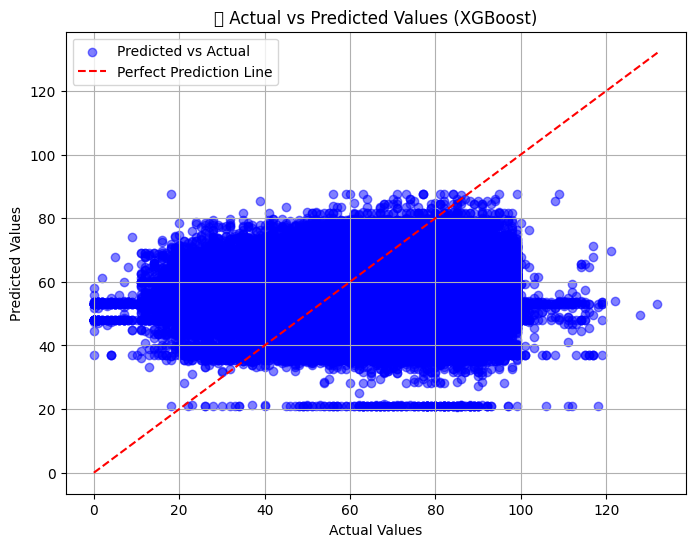

/home/codespace/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


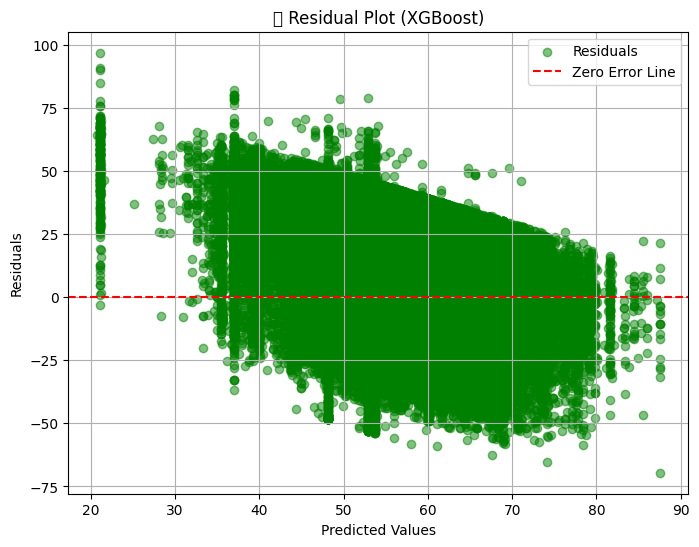

In [33]:

# Define XGBoost model with best parameters
best_xgb_model = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    enable_categorical=True,
    colsample_bytree=0.9198213766428692,
    gamma=2,
    learning_rate=0.05996280567850356,
    max_depth=8,
    n_estimators=457,
    reg_alpha=7,
    reg_lambda=4,
    subsample=0.860113640699105
)

# Train the model
best_xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = best_xgb_model.predict(X_test)

# Compute metrics
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_mae = mean_absolute_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)
test_mape = mean_absolute_percentage_error(y_test, y_pred)
test_msle = mean_squared_log_error(y_test, np.abs(y_pred))  # Ensure positive values for log error
test_explained_var = explained_variance_score(y_test, y_pred)
test_mse = mean_squared_error(y_test, y_pred)
residual_std = np.std(y_test - y_pred)
log_loss = -np.mean(norm.logpdf(y_test, loc=y_pred, scale=residual_std))

# Print evaluation metrics
print("📊 **XGBoost Benchmark Model Evaluation Metrics**")
print(f"✅ Test RMSE: {test_rmse:.4f}")
print(f"✅ Test MAE: {test_mae:.4f}")
print(f"✅ Test R² Score: {test_r2:.4f}")
print(f"✅ Test MAPE: {test_mape:.4%}")  # Display as percentage
print(f"✅ Test MSLE: {test_msle:.4f}")
print(f"✅ Explained Variance Score: {test_explained_var:.4f}")
print(f"✅ Test Log Loss: {log_loss:.4f}")

# 📌 Visualizing Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color="blue", label="Predicted vs Actual")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Perfect Prediction Line")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("📈 Actual vs Predicted Values (XGBoost)")
plt.legend()
plt.grid()
plt.show()

# 📌 Residual Plot
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.5, color="green", label="Residuals")
plt.axhline(y=0, color='r', linestyle='--', label="Zero Error Line")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("📉 Residual Plot (XGBoost)")
plt.legend()
plt.grid()
plt.show()
